<a href="https://colab.research.google.com/github/LubnaM/GANS/blob/main/GANs_Basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#source: https://www.youtube.com/watch?v=AALBGpLbj6Q

!pip install tensorflow ipywidgets tensorflow-datasets tensorflow-gpu

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
#Bringing tensorflow fashion_mnist dataset
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

ds=tfds.load('fashion_mnist', split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.WNIBRU_3.0.1/fashion_mnist-train.tfrecord*...:   …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.WNIBRU_3.0.1/fashion_mnist-test.tfrecord*...:   0…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
ds.as_numpy_iterator().next()['image'] #replace image by label to view the label

array([[[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 18],
        [ 77],
        [227],
        [227],
        [208],
        [210],
        [225],
        [216],
        [ 85],
        [ 32],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 61],
        [100],
        [ 97],
        [ 80],
        [ 57],
        [117],
        [227],
        [238],
        [115],
        [ 49],
        [ 78],
        [106],
        [108],
        [ 71],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [  0],
        [ 81],
        [105],
        [ 80],
        [ 69],
      

In [ ]:
import numpy as np
dataiterator=ds.as_numpy_iterator()


In [ ]:
batch=dataiterator.next() # in batch, image by image will be called if we call .next()


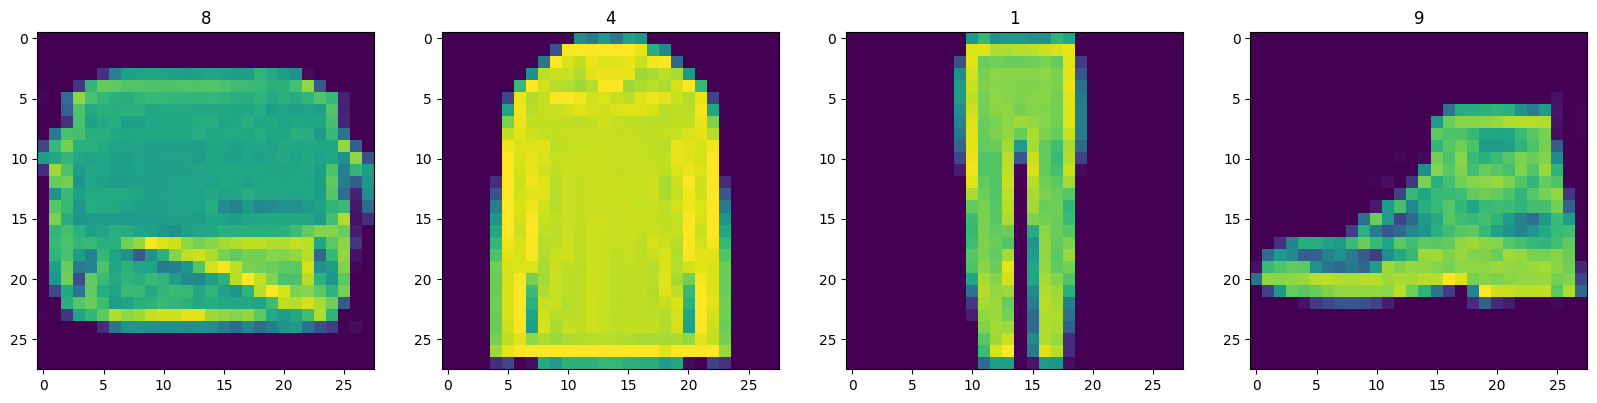

In [ ]:
#visualization of the dataset
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample=dataiterator.next() #sample here have 2 features image and label
    # This to plot image in to a sub plot, squeeze is to remove the 3rd dimention
    ax[idx].imshow(np.squeeze(sample['image']))
    # add image label as a title
    ax[idx].title.set_text(sample['label'])

In [ ]:
' Dataset preprocessing '
# Scaling the features to be between 0 and 1, instead of 1 to 255 ...
def scale_images(data):
  image=data['image']
  return image/255

In [ ]:
'--- Build the neural network ---'
#Conditional GAN is what we need to implement, we need to pass what type of text we want to generate. See this utube
#A data pipeline for building a tensorflow: cache > shuffle > batch > prefetch
ds=tfds.load('fashion_mnist', split='train')
#scale the image thru image function
ds=ds.map(scale_images)
#store intermediate results in memory or on disk. This can significantly speed up subsequent operations by avoiding the need to recompute results
ds=ds.cache()
ds=ds.shuffle(60000)
#Batch in to 128 images samples
ds=ds.batch(128)
#Prefetch reduces the bottlenecking
ds=ds.prefetch(64)

ds.as_numpy_iterator().next().shape


(128, 28, 28, 1)

In [ ]:
' now  generator will try to generate an image fashion, and discriminator will try to spot the fake image'
#Sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
#bring the layers for the neuralnetwork. LeakyRely
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Reshape, LeakyReLU, UpSampling2D, BatchNormalization


In [ ]:
def build_generator():
  model=Sequential()
  #what number of input to take
  #128 passed to generator of spatial latent dimentions 7 X 7 X128 hidden layer
  'takes in random value, and reshape it by 7*7*128, which is a begining of a generated image'
  model.add(Dense(7*7*128, input_dim=128)) # For generator this is a random input of 128 vector size, which we will use it to generate the image randomly.`
  # After a series of convolutional and pooling layers, you might end up with an output that has the shape of (7, 7, 128).
  # You would then flatten this output (which has 7 * 7 * 128 = 6272 elements) and pass it to a dense layer to combine these features into higher-level representations.
  model.add(LeakyReLU(0.2)) # to cater for non linearity
  model.add(Reshape((7,7,128))) # reshape will take a dense of output of 6272 and convert is in to a begining of an image

  'upsampling block1'
  model.add(UpSampling2D()) #
  model.add(Conv2D(128, kernel_size=5, padding='same'))
  model.add(LeakyReLU(0.2))

  'upsampling block2'
  model.add(UpSampling2D()) #
  model.add(Conv2D(128, kernel_size=5, padding='same'))
  model.add(LeakyReLU(0.2))

  'Conv block1'
  model.add(Conv2D(128, kernel_size=4, padding='same'))
  model.add(LeakyReLU(0.2))

  'Conv block2'
  model.add(Conv2D(128, kernel_size=4, padding='same'))
  model.add(LeakyReLU(0.2))

  'conv layer to get 1 output channel'
  model.add(Conv2D(1, kernel_size=4, padding='same', activation='sigmoid'))

  return model # only block 1 can be sufecient but adding more sofistication will allow the generator to learn


In [ ]:
generator=build_generator()
generator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 6272)                │         809,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 14, 14, 128)         │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 128)         │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 128)         │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 1)           │           2,049 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,155,137 (8.22 MB)

 Trainable params: 2,155,137 (8.22 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
img=generator.predict(np.random.rand(4,128,1))# 4 images


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


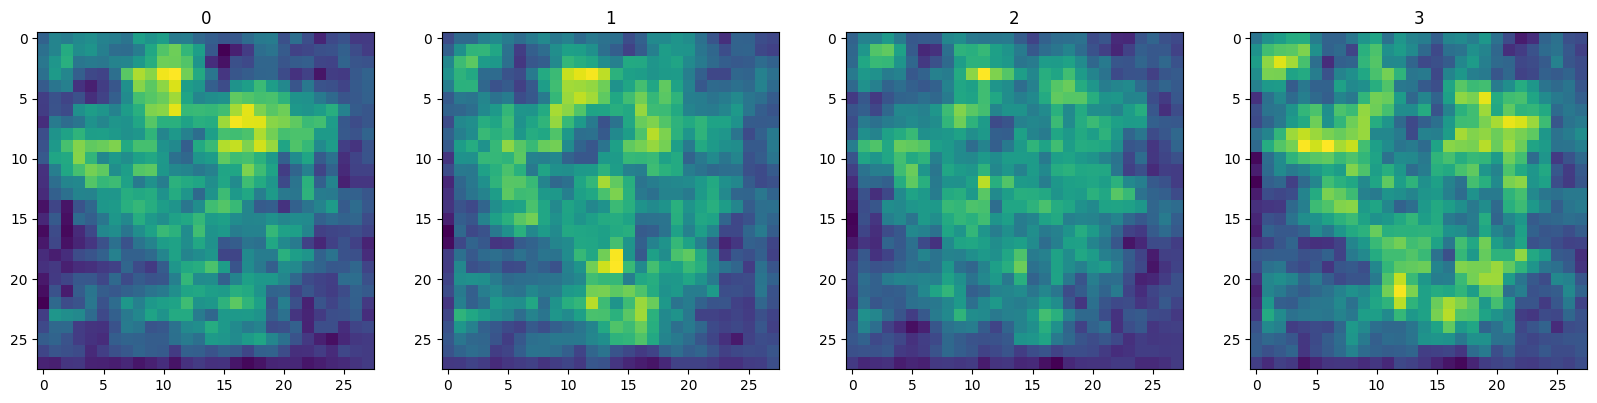

In [ ]:
'Generate new images and test generator'
#img
#visualize it
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(img):
    ax[idx].imshow(np.squeeze(img))
    ax[idx].title.set_text(idx)

In [ ]:
'-- Build the discriminator -- '
def build_discriminator():
  model=Sequential()
  #first conv block
  model.add(Conv2D(32, kernel_size=5, input_shape=(28,28,1))) #(28*28 will be pashed in to 32  filter with shape 5*5 , codensing down the information its getting)
  model.add(LeakyReLU(0.2)) # recomended practice when building GANs
  model.add(Dropout(0.4)) # for regularization
  #second conv block
  model.add(Conv2D(64, kernel_size=5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))
  #second conv block
  model.add(Conv2D(64, kernel_size=5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))
  #Third conv block
  model.add(Conv2D(128, kernel_size=5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))
  #Fourth conv block
  model.add(Conv2D(256, kernel_size=5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))
  #Flatten then pass to dense layer
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid')) # 1 is false image, and 0 is true image.

  return model

In [ ]:
discriminator=build_discriminator()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 24, 24, 32)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 20, 20, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 16, 16, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 12, 12, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 8, 8, 256)           │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │          16,385 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,195,329 (4.56 MB)

 Trainable params: 1,195,329 (4.56 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#test the generated images
discriminator.predict(img) # if 1 its a fake if less, its nearly near the truth value

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 834ms/step


array([[0.505551  ],
       [0.50553596],
       [0.5054914 ],
       [0.50552535]], dtype=float32)

In [ ]:
' - custom training loop to train the generator and discriminator simultanuesly -'
#setup some losses and optimizes
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

In [ ]:
g_opt = Adam(learning_rate=0.0001) #Generator faster
d_opt = Adam(learning_rate=0.00001) #discriminator we dont want discriminator to go too fast than generator
loss_fn = BinaryCrossentropy()

In [ ]:
import tensorflow as tf
tf.concat([tf.zeros_like(tf.random.normal((6,128))),tf.ones_like(tf.random.normal((6,128)))],axis=0) # This is  will be generating a bunch of ones in to the generator and g

<tf.Tensor: shape=(12, 128), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)>

In [ ]:
#importing the basemodel class to subclass our training step
from tensorflow.keras.models import Model
class FashionGAN(Model):
  def __init__(self, generator, discriminator, *args,**kwargs):
    # pass args and kwars to base class
    super().__init__(*args,**kwargs)
    #create attributes for generators and disc
    self.generator=generator
    self.discriminator=discriminator

  def compile(self,g_opt,d_opt,loss_fn,*args,**kwargs):
    super().compile(*args,**kwargs)
    self.g_opt=g_opt
    self.d_opt=d_opt
    self.loss_fn=loss_fn

  def train_step(self,batch): # batch can 128 images *28 * 28 *1)
    #get the data
    real_images=batch
    fake_images=self.generator(tf.random.normal((128,128,1)), training = False) # False means generator is not training at the moment its just making predictions

    #Train the discriminator
    with tf.GradientTape() as d_tape:
      #pass the real and fake model in to the discriminator model.
      yhat_real=self.discriminator(real_images, training=True)
      yhat_fake=self.discriminator(fake_images, training=True)
      yhat_realfake=tf.concat([yhat_real, yhat_fake], axis=0)
      #create labels, this below will assign the labels below are true y_realfake , a labels
      y_realfake=tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

      #add noise to the TRUE output to speedup learning
      noise_real = 0.15 * tf.random.uniform(tf.shape(yhat_real))
      noise_fake = -0.15 * tf.random.uniform(tf.shape(yhat_fake))
      y_realfake += tf.concat([noise_real, noise_fake],axis=0)

      #calsulate loss
      total_d_loss=self.loss_fn(y_realfake, yhat_realfake)
    #apply back propagation - nnlearn
    d_gradient=d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
    self.d_opt.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))


    #Train the generator
    with tf.GradientTape() as g_tape:
      #Generate some new images
      gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
      #Create the predicted labels, run generator images thru discriminator
      predicted_labels = self.discriminator(gen_images, training=False)#This will return a 1 if its fake #we dont discriminator to learn here, its just to determine the gen image is real or not.
      #Calculate loss, Trick to training to fake out the discriminator #what it tries to do is to generate images that tries to fakeing#  #here generator loss is rewarded, here generated image are actually real images, so we reward our generator for faking out the discriminator, if the discriminator predicts that a generated image is real
      total_g_loss = self.loss_fn(tf.zeros_like(predicted_labels), predicted_labels)
    #Apply backprob.
    g_gradient = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
    self.g_opt.apply_gradients(zip(g_gradient, self.generator.trainable_variables))#zip to do them both at the same time
    return {"d_loss":total_d_loss, "g_loss":total_g_loss}
#

In [ ]:
#create instance of subclass model
fashgan=FashionGAN(generator, discriminator)


In [ ]:
#Compile the model
fashgan.compile(g_opt, d_opt, loss_fn)

In [ ]:
'Build the call back'
import os
import tensorflow as tf
import tensorflow.keras.preprocessing.image as array_to_img
from tensorflow.keras.callbacks import Callback
os.makedirs('/content/drive/MyDrive/images', exist_ok=True)


In [ ]:
class ModelMonitor(Callback):
  def __init__(self, num_img=3, latent_dim=128):#just the random value u r passing to generate
    self.num_img=num_img
    self.latent_dim=latent_dim
  def on_epoch_end(self, epoch, logs=None):
    #generate random
    random_latent_vectors=tf.random.uniform(shape=(self.num_img, self.latent_dim,1))
    generated_images=self.model.generator(random_latent_vectors)
    generated_images *= 255
    generated_images.numpy()
    for i in range(self.num_img):
      img = array_to_img.array_to_img(generated_images[i])
      img.save(os.path.join('/content/drive/MyDrive/images', f'generated_img{i}_{epoch}.png'))

In [ ]:
'Train the model'
hist=fashgan.fit(ds, epochs=20, callbacks=[ModelMonitor()])

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 91s 194ms/step - d_loss: 0.2863 - g_loss: 4.7708
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 195ms/step - d_loss: 0.2737 - g_loss: 2.6836
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 92s 195ms/step - d_loss: 0.2983 - g_loss: 2.6207
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 91s 194ms/step - d_loss: 0.5862 - g_loss: 0.6548
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 143s 195ms/step - d_loss: 0.4200 - g_loss: 0.1148
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 91s 195ms/step - d_loss: 0.4751 - g_loss: 0.6079
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 195ms/step - d_loss: 0.3079 - g_loss: 0.0457
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 91s 194ms/step - d_loss: 0.3004 - g_loss: 0.0550
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 91s 193ms/step - d_loss: 0.3813 - g_loss: 0.1035
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 90s 193ms/step - d_loss: 0.7149 - g_loss: 0.5507
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 142s 193ms/step - d_loss: 0.6934 - g_loss: 0.6514
Epoch 12/20
469

In [ ]:
#Review the performance
#we saved out training in a variable called hist, then we can print it and see its performance
hist.history

{'d_loss': [0.26480257511138916,
  0.2753564715385437,
  0.5845614671707153,
  0.5213609933853149,
  1.0368608236312866,
  0.32817500829696655,
  0.3049609363079071,
  0.28025004267692566,
  0.5420096516609192,
  0.7018244862556458,
  0.7275745272636414,
  0.6987859606742859,
  0.6863042116165161,
  0.6829312443733215,
  0.6855176091194153,
  0.7007043361663818,
  0.6804574131965637,
  0.6940840482711792,
  0.6946175694465637,
  0.6993058323860168],
 'g_loss': [2.6145706176757812,
  2.675790309906006,
  0.8210332989692688,
  0.3255122900009155,
  0.2113627940416336,
  0.05567222461104393,
  0.051918838173151016,
  0.0530412495136261,
  0.1770012378692627,
  0.6060915589332581,
  0.6552852392196655,
  0.6814717650413513,
  0.6855946779251099,
  0.6763290166854858,
  0.64884352684021,
  0.6569682955741882,
  0.7101796865463257,
  0.6703968644142151,
  0.6763064861297607,
  0.6785511374473572]}

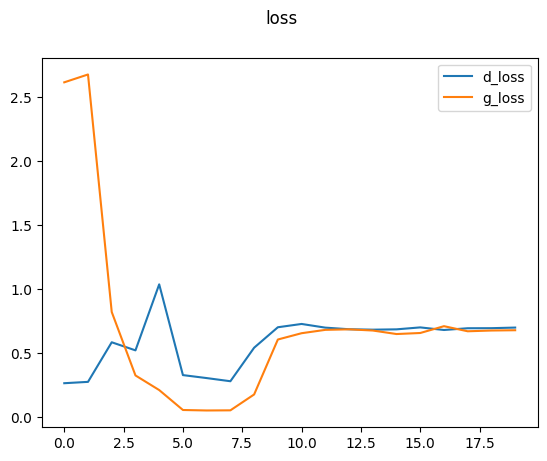

In [ ]:
plt.suptitle('loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

#The performance might enhance if we go and train it for 2000 epocs

In [ ]:
'Test the Generator Model'
#before loading the pretrain model, lets test that with baseline model

imgs = generator.predict(tf.random.normal((16,128,1))) # generate 16 images, laten variable 128, then 1)
imgs

'''
Another pretrained model can be downloaded from here :
generatormodel.h5
https://github.com/nicknochnack/GANBasics
and to load its weights:
generator.load_weights('generatormodel.h5')
'''

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


"\nAnother pretrained model can be downloaded from here :\ngeneratormodel.h5\nhttps://github.com/nicknochnack/GANBasics\nand to load its weights:\ngenerator.load_weights('generatormodel.h5')\n"

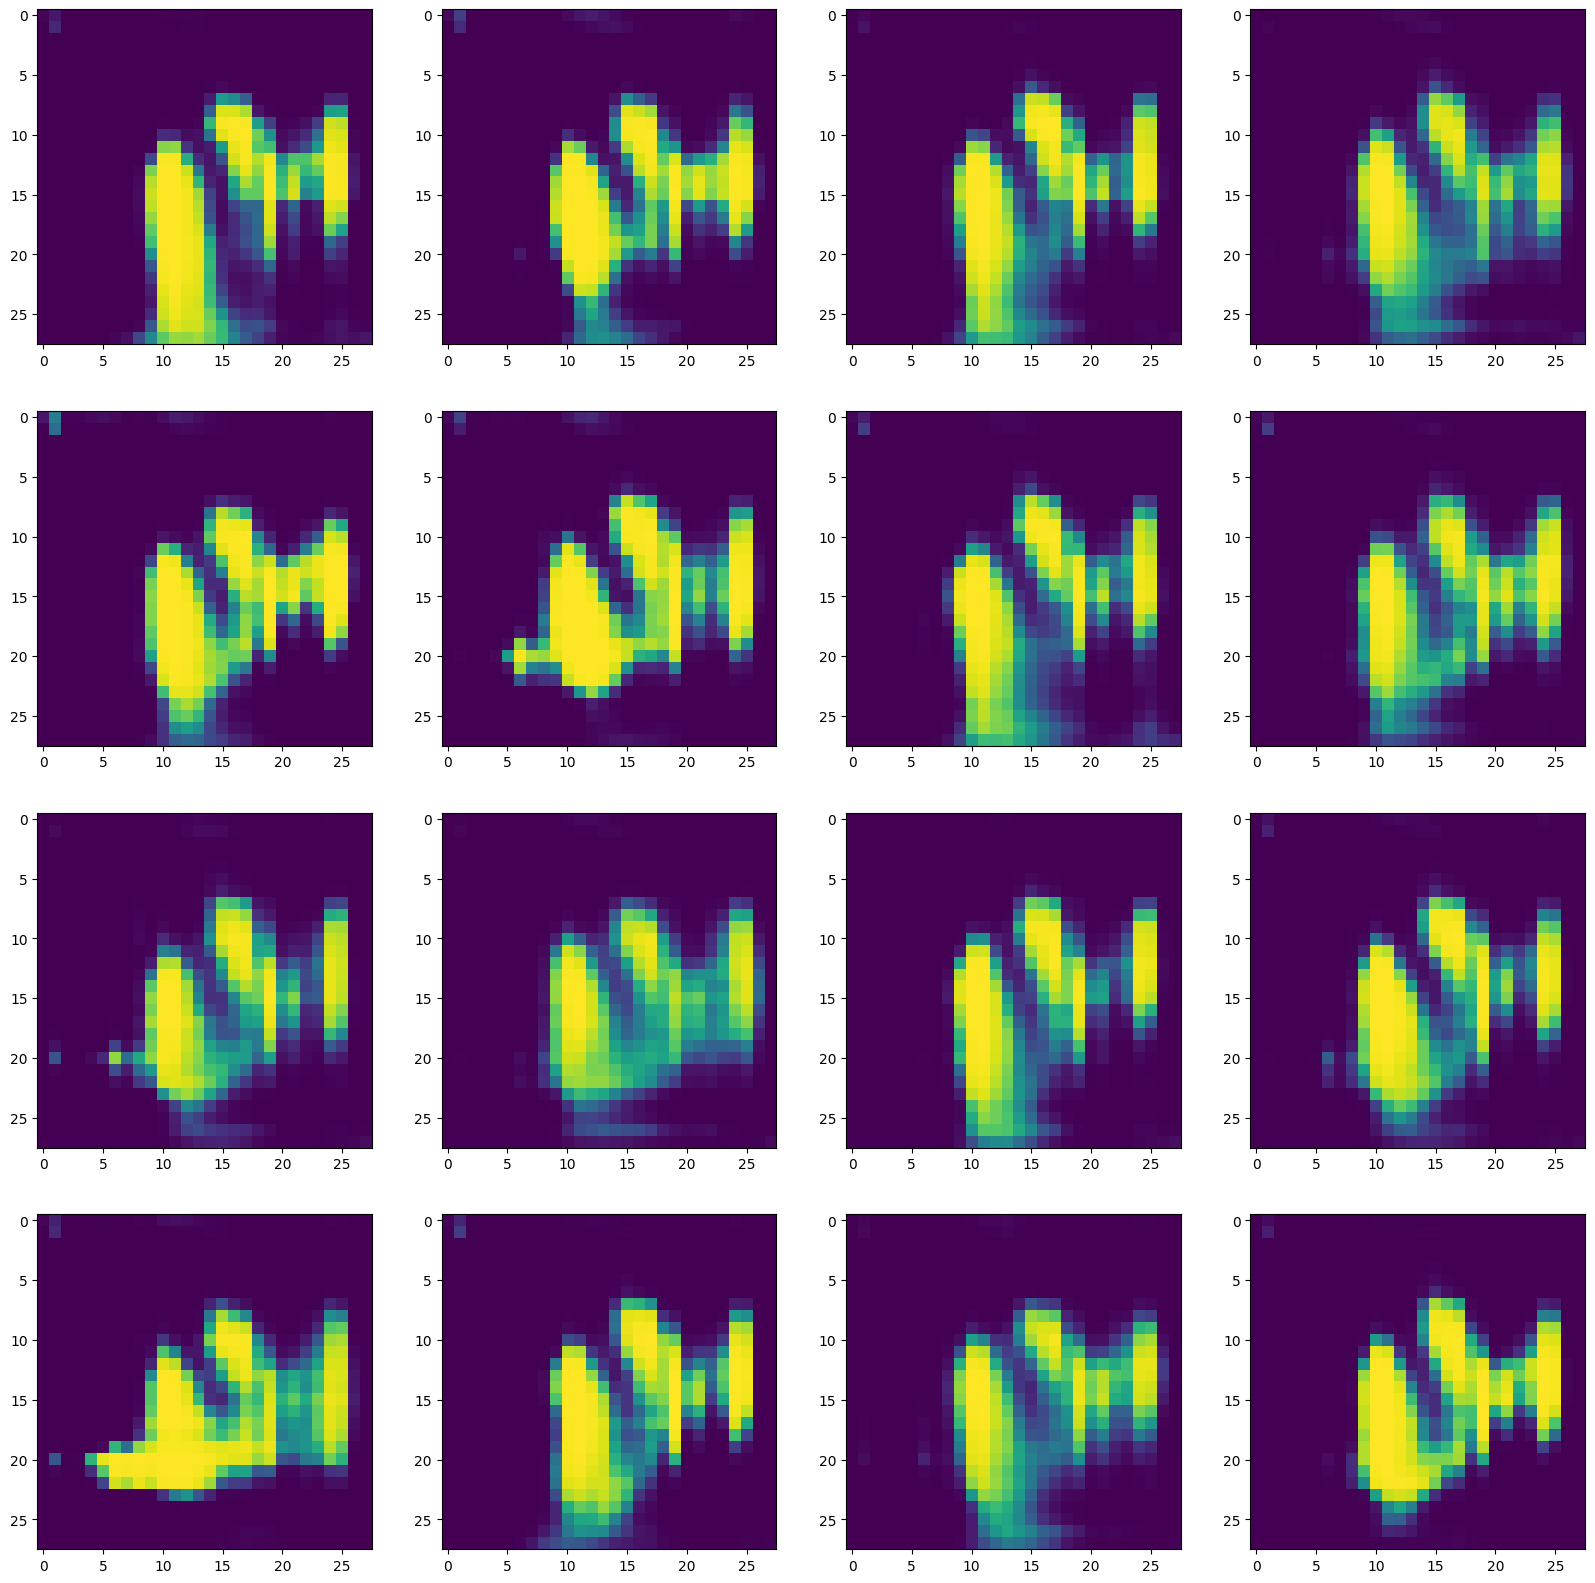

In [ ]:
fig, axs = plt.subplots(ncols=4,nrows=4, figsize=(20,20)) # changed ax to axs
for idx, img in enumerate(imgs):
    axs.flat[idx].imshow(np.squeeze(img)) # use flat iterator to correctly index the subplots
plt.show()